In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 

In [2]:
class Persona:
    def __init__(self,resource,productivity,science,wealth,income,saving,salary,InvestIncome,lifestatus,
                GainedInvest,PayInvest,WorkIncome,empleados,status,indice,production,clase,consumption):
        self.resource=resource
        self.productivity=productivity
        self.science=science
        self.wealth=wealth
        self.income=income
        self.saving=saving
        self.salary=salary
        self.InvestIncome=InvestIncome
        self.GainedInvest=GainedInvest
        self.PayInvest=PayInvest
        self.lifestatus=lifestatus #0->vivo #1-> muerto
        self.WorkIncome=WorkIncome
        self.empleados=empleados
        self.status=status #0->empleado #2->investor #1->ni empleado ni investor
        self.indice=indice
        self.production=production
        self.clase=clase
        self.consumption=consumption
    #asignar indice
    def a_indice(self,i):
        self.indice=i
    #calcular productivity
    def initial_productivity(self,mean,desviacion,t):
        p=random.gauss(mean,desviacion)
        if (p>0):
            self.productivity[t]=p
    #calcular production inicial
    def initial_production(self,t):
        self.production[t]=self.resource*self.productivity[t]*self.science
    def initial_wealth(self,i_wealth,t):
        self.wealth[t]=i_wealth
    def initial_saving(self,i_sav,t):
        self.saving[t]=i_sav
    #def initial_status(self,i_status,t):
        #self.status[t]=i_status
    #introducir empleados si es investor
    def guardar_empleado(self,identificador): #me va a guardar el indice de cada empleado
        self.empleados.append(identificador)

    


In [3]:
#calcular productividad para cada año
def c_productivity(agentes,t):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            agentes[i].productivity[t]=agentes[i].productivity[t-1]

In [4]:
#calcular production
def c_production(agentes,t):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            produc=agentes[i].resource*agentes[i].productivity[t]*agentes[i].science
            agentes[i].production[t]=produc

In [5]:
#calcular workIncome
def c_workincome(agentes,t):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            if (agentes[i].status==2): #si es inversionista
                agentes[i].WorkIncome[t]=agentes[i].production[t]
            if (agentes[i].status==0 or agentes[i].status==3): #si es empleado agregar status 3
                agentes[i].WorkIncome[t]=agentes[i].salary
            if (agentes[i].status==1): #si no es empleado ni inversionista
                agentes[i].WorkIncome[t]=agentes[i].production[t]

In [6]:
#creamos una funcion para definir el investincome
def c_investincome(agentes,t):
    invest=0
    for j in range(len(agentes)):
        if (agentes[j].status==2 and agentes[j].lifestatus==0):
            for k in agentes[j].empleados:
                invest=invest+agentes[k].production[t]-agentes[k].salary
            agentes[j].InvestIncome[t]=invest


In [7]:
#creamos una funcion para el income
def c_income(agentes,t):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            inc=agentes[i].WorkIncome[t]+agentes[i].InvestIncome[t]
            agentes[i].income[t]=inc

In [8]:
#creamos una funcion para wealth
def c_wealth(agentes,t,tau):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            w=agentes[i].income[t]+agentes[i].saving[t-1]*(1-1.0/tau)
            agentes[i].wealth[t]=w

In [9]:
#creamos funcion de distribucion de clase [0 alive,1 enough,2 satisfied,3 luxury]
def dist_clase(lista_consumo,agentes,t,conteo_broke):
    for i in range(len(agentes)):
        if(agentes[i].lifestatus==0):
            for s in range(len(lista_consumo)):
                if (s!=len(lista_consumo)-1):
                    min=lista_consumo[s]
                    max=lista_consumo[s+1]
                    if (agentes[i].wealth[t]>=min and agentes[i].wealth[t]<max):
                        agentes[i].clase=s
                if (s==len(lista_consumo)-1):
                    if (agentes[i].wealth[t]>=max):
                         agentes[i].clase=s
            if (agentes[i].wealth[t]<lista_consumo[0]):
                    ind=agentes[i].indice
                    #print(ind,t)
                    broke_sale(ind,agentes,lista_consumo[0],5000,t,conteo_broke)

In [10]:
#asignar consumo a cada uno
def asignar_consumo(agentes,lista_consumo,t):
    l_desviaciones=[500,1500,4*10**4,2*10**5]
    for i in range(len(agentes)):
        if(agentes[i].lifestatus==0):
            for s in range(len(lista_consumo)):
                if agentes[i].clase==s:
                    c=np.abs(random.gauss(0,l_desviaciones[s]))
                    consumo=lista_consumo[s]+c
                    if (consumo>=lista_consumo[s] and consumo<agentes[i].wealth[t]):
                        agentes[i].consumption[t]=consumo
                    if (consumo<lista_consumo[s] or consumo>agentes[i].wealth[t]):
                        agentes[i].consumption[t]=lista_consumo[s]
                    if (agentes[i].wealth[t]<lista_consumo[0]): #si esta muerto
                        agentes[i].consumption[t]=0

In [11]:
#funcion de interaccion tipo Broke sale
def broke_sale(i,agentes,e_alive,e_satisfied,t,conteo_broke):

#for j in range(len(agentes)):
    if(agentes[i].wealth[t]<e_alive):
        j=random.randint(0,len(agentes)-1)
        expected_productivity=0
        expected_production=0
        if(i!=j and agentes[j].wealth[t]>=1*10**4):
            expected_productivity=np.divide(agentes[i].productivity[t]+agentes[j].productivity[t],2)
            expected_production=agentes[i].resource*expected_productivity*agentes[i].science
        #print('riqueza i antes de broke sale',agentes[i].wealth[t],t)
        if ((expected_production-e_alive>0) and (agentes[j].status!=0 and agentes[j].status!=3)):
            conteo_broke[t]+=1
            #agentes[j].resource[t]=agentes[j].resource[t]+agentes[i].resource[t]
            #agentes[i].resource[t]=1
            #venta del recurso
            #print('riqueza j antes de broke sale',agentes[j].wealth[t])
            #print('i',i,'j',j,'t',t)
            agentes[i].GainedInvest[t]=e_alive
            #cambio en la energia
            #agentes[i].wealth[t]=agentes[i].wealth[t]+e_alive
            #agentes[j].wealth[t]=agentes[j].wealth[t]-e_alive
            #print('riqueza i despues bsale',agentes[i].wealth[t])
            #print('riqueza j despues bsale',agentes[j].wealth[t])
            #cambia la productividad
            agentes[i].productivity[t]=np.divide(agentes[i].productivity[t]+agentes[j].productivity[t],2)
            #agentes[i].c_production(t)
            agentes[i].salary=e_alive
            agentes[j].guardar_empleado(agentes[i].indice)
            #agentes[i].status[t]=0
            #agentes[j].status[t]=2
            setattr(agentes[i],'status',0)#cambiar status->empleado
            setattr(agentes[j],'status',2)#cambiar status->investor


In [12]:
def premium_buying(agentes,t,conteo_premium):
    pot_sellers=[]
    pot_investors=[]
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            if ((agentes[i].productivity[t]<10000 and agentes[i].productivity[t]>5000) and (agentes[i].status==1)):
                    pot_sellers.append(agentes[i])
                    #print('seller',agentes[i].indice)
            if ((agentes[i].productivity[t]>22000) and (agentes[i].status!=0 and agentes[i].status!=3)):
                    pot_investors.append(agentes[i])
                    #print('investor',agentes[i].indice)
    
    #ordenamos los sellers con su productividad
    pot_sellers.sort(key=lambda x: x.productivity[t])
    #calculmamos suma potenctial investors
    suma=sum(c.wealth[t] for c in pot_investors)
    #print(suma)
    
    #calculamos probabilidad individual
    probj=0
    #tomar un investor aleatorio y calcular su probabilidad
    for m in pot_sellers:
        j=random.randint(0,len(pot_investors)-1)
        probj=np.divide(pot_investors[j].wealth[t],suma)
        #print('probabilidad',probj)
        if (probj>0.2):
                conteo_premium[t]+=1
                m.GainedInvest[t]=2*m.consumption[t]
                m.salary=1.1*m.production[t]
                m.productivity[t]=np.divide(m.productivity[t]
                                                         +pot_investors[j].productivity[t],2)
                pot_investors[j].guardar_empleado(m.indice)
                #m.status[t]=3
                #pot_investors[j].status[t]=2
                setattr(m,'status',3)#cambiar status a 3->empleado premium buying
                setattr(pot_investors[j],'status',2)#cambiar status a 2->investor
                #print(m.status)
                

        
                


In [13]:
def check_premium(agentes,t,conteo_broke,conteo_premium):
    if conteo_broke[t]==0 and t>5:
        premium_buying(agentes,t,conteo_premium)
    

In [14]:
#funcion para borrar personas que mueren
def borrar_agente(agentes,e_alive,t):
    for i in range(len(agentes)):
        if (agentes[i].wealth[t]<e_alive and agentes[i].status!=0):
            setattr(agentes[i],'lifestatus',1) #pasar su estado a muerto
            #print('agente que murio',agente.indice)
            #print('life status agente muerto',agente.lifestatus)
            #print('año de muerte',t)


In [15]:
#calcular PayInvest
def pay_invest(agentes,t):
    pi=0
    for j in range(len(agentes)):
        if (agentes[j].status==2 and agentes[j].lifestatus==0):
            for k in agentes[j].empleados:
                pi=pi+agentes[k].GainedInvest[t]
                #print('cada paso de tiempo',pi)
            agentes[j].PayInvest[t]=pi
            #print('final pi',pi)
            pi=0
        #print('pi vaciado',pi)

In [16]:
#calcular saving
def c_saving(agentes,t):
    sav=0
    for i in range(len(agentes)):
        if(agentes[i].lifestatus==0):
            sav=agentes[i].wealth[t]+agentes[i].GainedInvest[t]-agentes[i].consumption[t]-agentes[i].PayInvest[t]
            #print(sav,t)
            agentes[i].saving[t]=sav
            '''
        if (agentes[i].status==0):
            sav=agentes[i].wealth[t]-2500+agentes[i].GainedInvest[t]-agentes[i].consumption[t]-agentes[i].PayInvest[t]
            agentes[i].saving[t]=sav
        if (agentes[i].status==1 and agentes[i].wealth[t]>=2500):
            sav=agentes[i].wealth[t]+agentes[i].GainedInvest[t]-agentes[i].consumption[t]-agentes[i].PayInvest[t]
            agentes[i].saving[t]=sav
        if (agentes[i].status==1 and agentes[i].wealth[t]<2500):
            sav=0
            agentes[i].saving[t]=sav
        '''

In [17]:
#creamos funcion para contar el numero de agentes en cada clase
def conteo_clase(agentes,clase0,clase1,clase2,clase3,t):
    s0=0
    s1=0
    s2=0
    s3=0
    for i in range(len(agentes)):
        if agentes[i].clase==0:
            s0=s0+1
        if agentes[i].clase==1:
            s1=s1+1
        if agentes[i].clase==2:
            s2=s2+1
        if agentes[i].clase==3:
            s3=s3+1
    clase0[t]=s0
    clase1[t]=s1
    clase2[t]=s2
    clase3[t]=s3 

In [18]:
#funcion contar numero de seller broke sale y premium buying
def conteo_seller(agentes,num_brokesale,num_premium,t):
    nbroke=0
    npremium=0
    for i in range(len(agentes)):
        if agentes[i].status==0:
            nbroke=nbroke+1
        if agentes[i].status==3:
            npremium=npremium+1
    num_brokesale[t]=nbroke
    num_premium[t]=npremium

In [19]:
#Inicializacion por defecto creamos un vector de objetos y lo llenamos

def inicializar(N,n_tsteps,agentes,alive,enough,satisfied,luxury):
    #poblacion=[]#array de objetos que tiene a cada persona
    #N=1*10**4
    #n_tsteps=100
    empleados_per=[]
    l_production=np.zeros(n_tsteps)
    l_workincome=np.zeros(n_tsteps)
    l_investincome=np.zeros(n_tsteps)
    l_gainedinvest=np.zeros(n_tsteps)
    l_payinvest=np.zeros(n_tsteps)
    l_income=np.zeros(n_tsteps)
    l_wealth=np.zeros(n_tsteps)
    l_saving=np.zeros(n_tsteps)
    l_consumption=np.zeros(n_tsteps)
    l_productivity=np.zeros(n_tsteps)
    l_status=np.zeros(n_tsteps)
    '''
    l_alive=np.zeros(n_tsteps)
    l_enough=np.zeros(n_tsteps)
    l_satisfied=np.zeros(n_tsteps)
    l_luxury=np.zeros(n_tsteps)
    n_brokesale=np.zeros(n_tsteps)
    n_premium=np.zeros(n_tsteps)
    '''
    '''
    Persona(self,resource,productivity,science,wealth,income,saving,salary,InvestIncome,lifestatus,
                    GainedInvest,PayInvest,WorkIncome,empleados,status,indice,production,clase,consumption):
    '''   
    #para ---t=0-------
    for i in range(N):
        per=Persona(1,l_productivity,1,l_wealth,l_income,l_saving,0,l_investincome,0,l_gainedinvest
                    ,l_payinvest,l_workincome,empleados_per,1,0,l_production,0,l_consumption)
        agentes.append(per) #introducimos cada objeto en el array
        agentes[i].a_indice(i)#le asignamos su indice a cada uno
        agentes[i].initial_productivity(5000,5000,0)#calculamos la productividad para cada uno mean y sd 5000
        agentes[i].initial_production(0) #calculamos la produccion segun productivity
        agentes[i].initial_wealth(5000,0)#asignamos inicialmente a todos la misma riqueza 5000
        agentes[i].initial_saving(5000,0)#el mismo ahorro inicial 5000
        #poblacion[i].initial_status(1,0)
        #poblacion[i].c_production(1)#calculamos la del año 1
        l_workincome=np.zeros(n_tsteps)
        l_production=np.zeros(n_tsteps)
        l_workincome=np.zeros(n_tsteps)
        l_investincome=np.zeros(n_tsteps)
        l_gainedinvest=np.zeros(n_tsteps)
        l_payinvest=np.zeros(n_tsteps)
        l_income=np.zeros(n_tsteps)
        l_wealth=np.zeros(n_tsteps)
        l_saving=np.zeros(n_tsteps)
        l_consumption=np.zeros(n_tsteps)
        l_productivity=np.zeros(n_tsteps)
        #l_status=np.zeros(n_tsteps)
        empleados_per=[]
    conteo_clase(poblacion,alive,enough,satisfied,luxury,0)
    #conteo_seller(poblacion,n_brokesale,n_premium,0)

In [20]:
#inicializar(100,100,poblacion)

In [21]:

def evolucion(n_tsteps,agentes,conteo_broke,conteo_premium,alive,enough,satisfied,luxury):
    #----para t=1 hasta n_timesteps-1-----
    #for t in range(1,n_timesteps,1):
    #para t=1
    random.seed(0)
    lista_clase=[2500,7500,2*10**5,10**6]
    for t in range(1,n_tsteps,1):
        #---primer paso------(1)
        c_productivity(agentes,t)
        c_production(agentes,t)
        c_workincome(agentes,t)
        c_investincome(agentes,t) 
        c_income(agentes,t)
        c_wealth(agentes,t,2)
        #---segundo paso-----(2) dist. clase y asignar consumo
        dist_clase(lista_clase,agentes,t,conteo_broke)
        #check_premium(poblacion,lista_clase,t)
        borrar_agente(agentes,lista_clase[0],t)
        asignar_consumo(agentes,lista_clase,t)
        #ellos van a hacer premium buying despues de hacer broke sale
        check_premium(agentes,t,n_brokesale,conteo_premium)
        c_production(agentes,t)#calculamos de nuevo production pues cambio la productividad
        #----tercer paso------(3)payinvest
        pay_invest(agentes,t)
        #----cuarto paso-----(4) saving
        c_saving(agentes,t)
        conteo_clase(agentes,alive,enough,satisfied,luxury,t)
        #conteo_seller(poblacion,n_brokesale,n_premium,t)
    '''
    for i in range(len(poblacion)):

        #print('workincome'+str(i),poblacion[i].WorkIncome)
        #print('investincome'+ str(i),poblacion[i].InvestIncome)
        #print('income'+str(i),poblacion[i].income)
        print('wealth'+str(i),poblacion[i].wealth)
        #print('clase'+str(i),poblacion[i].clase)
        print('gainedinvest'+str(i),poblacion[i].GainedInvest)
        print('consumo'+str(i),poblacion[i].consumption)
        print('payinvest'+str(i),poblacion[i].PayInvest)
        print('empleados'+str(i),poblacion[i].empleados)
        #print('saving'+str(i),poblacion[i].saving)
        print('status'+str(i),poblacion[i].status)
        #print('production'+str(i),poblacion[i].production)
        print('productivity'+str(i),poblacion[i].productivity)
        #print('lifestatus'+str(i),poblacion[i].lifestatus)
    '''

In [27]:
#parametros iniciales
poblacion=[]
time_steps=100
N=1*10**4
nsim=2
l_alive=np.zeros(time_steps)
l_enough=np.zeros(time_steps)
l_satisfied=np.zeros(time_steps)
l_luxury=np.zeros(time_steps)
n_brokesale=np.zeros(time_steps)
n_premium=np.zeros(time_steps)
#productividad cuatro años
pro_0=[]
pro_2=[]
pro_10=[]
pro_99=[]
pro_y0=np.zeros([nsim,N])
pro_y2=np.zeros([nsim,N])
pro_y10=np.zeros([nsim,N])
pro_y99=np.zeros([nsim,N])
#productividad por clase ultimo año
ali=[]
eno=[]
sat=[]
lux=[]
pro_ali=np.zeros(N)
pro_eno=np.zeros(N)
pro_sat=np.zeros(N)
pro_lux=np.zeros(N)

#empezamos la simulacion

for n in range(nsim):
    inicializar(N,time_steps,poblacion,l_alive,l_enough,l_satisfied,l_luxury)
    evolucion(time_steps,poblacion,n_brokesale,n_premium,l_alive,l_enough,l_satisfied,l_luxury)
    for l in range(len(poblacion)):
        pro_0.append(poblacion[l].productivity[0])
        pro_2.append(poblacion[l].productivity[2])
        pro_10.append(poblacion[l].productivity[10])
        pro_99.append(poblacion[l].productivity[99])
        if poblacion[l].clase==0:
            ali.append(poblacion[l].productivity[time_steps-1])
        if poblacion[l].clase==1:
            eno.append(poblacion[l].productivity[time_steps-1])
        if poblacion[l].clase==2:
            sat.append(poblacion[l].productivity[time_steps-1])
        if poblacion[l].clase==3:
            lux.append(poblacion[l].productivity[time_steps-1])
    #llenar listas productividad
    pro_y0[n]=np.sort(pro_0)
    pro_y2[n]=np.sort(pro_2)
    pro_y10[n]=np.sort(pro_10)
    pro_y99[n]=np.sort(pro_99)
    #llenar listas productividad por clase
    pro_alisort=np.sort(ali)
    pro_enosort=np.sort(eno)
    pro_satsort=np.sort(sat)
    pro_luxsort=np.sort(lux)
    for p in range(len(pro_alisort)):
        pro_ali[p]=pro_ali[p]+np.divide(pro_alisort[p],1.0*nsim)
    for k in range(len(pro_enosort)):
        pro_eno[k]+=np.divide(pro_enosort[k],1.0*nsim)
    for v in range(len(pro_satsort)):
        pro_sat[v]+=np.divide(pro_satsort[v],1.0*nsim)
    for j in range(len(pro_luxsort)):
        pro_lux[j]+=np.divide(pro_luxsort[j],1.0*nsim)
    #vaciar todo para nueva simulacion
    pro_0=[]
    pro_2=[]
    pro_10=[]
    pro_99=[]
    poblacion=[]
    ali=[]
    eno=[]
    sat=[]
    lux=[]
    l_alive=np.zeros(time_steps)
    l_enough=np.zeros(time_steps)
    l_satisfied=np.zeros(time_steps)
    l_luxury=np.zeros(time_steps)
    n_brokesale=np.zeros(time_steps)
    n_premium=np.zeros(time_steps)

In [ ]:
#sacar promedios de las simulaciones
pro_0mean=np.mean(pro_y0,axis=0)
pro_2mean=np.mean(pro_y2,axis=0)
pro_10mean=np.mean(pro_y10,axis=0)
pro_99mean=np.mean(pro_y99,axis=0)


Text(0.5, 1.0, 'Distribucion de productividad para cuatro años diferentes')

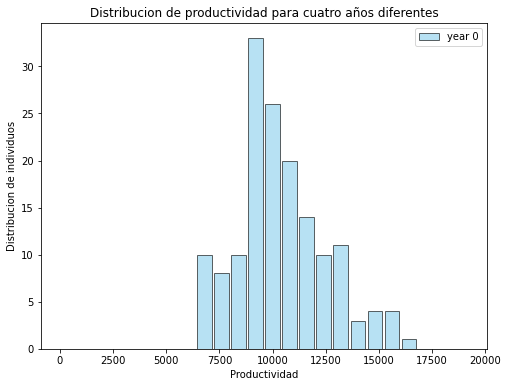

In [31]:
fig = plt.figure(figsize=(8,6))
intervalos=range(1,20000,800)
plt.hist(pro_sat,bins=intervalos,color="skyblue",
         rwidth=0.85,lw=1,edgecolor='black',alpha=0.6,label='year 0')
#plt.hist([pro_y10],bins=intervalos,color="green",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 2')
#plt.hist(pro_y10,bins=intervalos,color="black",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 10')
#plt.hist(pro_y29,bins=intervalos,color="purple",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 29')
plt.legend(loc='upper right')
plt.xlabel('Productividad')
plt.ylabel('Distribucion de individuos')
plt.title('Distribucion de productividad para cuatro años diferentes')
#fig.savefig('productividad_difanos2.png')

In [ ]:
#print(poblacion[50].WorkIncome[5])
#print(n_brokesale)
#print(n_premium)
print(poblacion[0].status)
print(poblacion[85].income[1])

In [ ]:
#lista de productividad para varios años
pro_y0=[]
pro_y2=[]
pro_y10=[]
pro_y29=[]
for l in range(len(poblacion)):
    pro_y0.append(poblacion[l].productivity[0])
    pro_y2.append(poblacion[l].productivity[2])
    pro_y10.append(poblacion[l].productivity[10])
    pro_y29.append(poblacion[l].productivity[29])


In [ ]:
fig = plt.figure(figsize=(8,6))
intervalos=range(1,20000,800)
plt.hist([pro_y0,pro_y2,pro_y10,pro_y29],bins=intervalos,color=["skyblue","green","orange","purple"],
         rwidth=0.85,lw=1,edgecolor='black',alpha=0.6,label=['year 0','year2','year10','year99'])
#plt.hist([pro_y10],bins=intervalos,color="green",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 2')
#plt.hist(pro_y10,bins=intervalos,color="black",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 10')
#plt.hist(pro_y29,bins=intervalos,color="purple",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 29')
plt.legend(loc='upper right')
plt.xlabel('Productividad')
plt.ylabel('Distribucion de individuos')
plt.title('Distribucion de productividad para cuatro años diferentes')
#fig.savefig('productividad_difanos2.png')

In [ ]:
#lista de productividad por clase ultimo año
pro_ali=[]
pro_eno=[]
pro_sat=[]
pro_lux=[]
for p in range(len(poblacion)):
    if poblacion[p].clase==0:
        pro_ali.append(poblacion[p].productivity[time_steps-1])
    if poblacion[p].clase==1:
        pro_eno.append(poblacion[p].productivity[time_steps-1])
    if poblacion[p].clase==2:
        pro_sat.append(poblacion[p].productivity[time_steps-1])
    if poblacion[p].clase==3:
        pro_lux.append(poblacion[p].productivity[time_steps-1])

In [ ]:
#grafica distribucion de productividad por clase
fig = plt.figure(figsize=(8,6))
intervalos=range(1,20000,800)
plt.hist([pro_ali,pro_eno,pro_sat,pro_lux],bins=intervalos,color=["blue","lime","m","yellow"],
         rwidth=0.85,lw=1,edgecolor='black',alpha=0.6,label=['Alive','Enough','Satisfied','Luxury'])
#plt.hist([pro_y10],bins=intervalos,color="green",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 2')
#plt.hist(pro_y10,bins=intervalos,color="black",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 10')
#plt.hist(pro_y29,bins=intervalos,color="purple",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 29')
plt.legend(loc='upper right')
plt.xlabel('Productividad')
plt.ylabel('Distribucion de individuos')
plt.title('Distribucion de productividad por clase para el ultimo año')
#fig.savefig('productividad_clase2.png')

In [ ]:
#sacar el ingreso del ultimo año
ing1=[]
ing4=[]
ing10=[]
ing39=[]
for k in range(len(poblacion)):
    ing1.append(poblacion[k].income[1])
    ing4.append(poblacion[k].income[4])
    ing10.append(poblacion[k].income[10])
    ing39.append(poblacion[k].income[99])
    

In [ ]:
#grafica distribucion de ingreso para varios años
fig = plt.figure(figsize=(8,6))
intervalos=range(1,25000,1000)
plt.hist([ing1,ing4,ing10,ing39],bins=intervalos,color=["blue","lime","m","yellow"],
         rwidth=0.85,lw=1,edgecolor='black',alpha=0.6,label=['Year 1','Year 4','Year 10','Year 99'])
#plt.hist([pro_y10],bins=intervalos,color="green",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 2')
#plt.hist(pro_y10,bins=intervalos,color="black",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 10')
#plt.hist(pro_y29,bins=intervalos,color="purple",rwidth=0.85,lw=1,edgecolor='black',alpha=0.5,label='year 29')
plt.legend(loc='upper right')
plt.xlabel('Ingreso')
plt.ylabel('Distribucion de individuos')
plt.title('Distribucion de ingreso para cuatro años')
#fig.savefig('ingreso2.png')

In [ ]:
lista_t=[]
for l in range(0,time_steps,1):
    lista_t.append(l)
print(lista_t)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(lista_t,l_alive,color='red',marker='o',alpha=0.5,label='Alive')
plt.plot(lista_t,l_enough,color='lime',marker='o',alpha=0.5,label='Enough')
plt.plot(lista_t,l_satisfied,color='blue',marker='o',alpha=0.5,label='Satisfied')
plt.plot(lista_t,l_luxury,color='m',marker='o',alpha=0.5,label='Luxury')
plt.xlabel('Tiempo t (años)')
plt.ylabel('Numero de personas')
plt.legend(loc='upper right')
#fig.savefig('dif_clase2.png')

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(lista_t,n_brokesale,'red',marker='<',alpha=0.5,label='Broke Sale')
plt.plot(lista_t,n_premium,'blue',marker='<',alpha=0.5,label='Premium Buying')
plt.xlabel('Tiempo t (años)')
plt.ylabel('Numero de vendedores')
plt.legend(loc='upper right')
#fig.savefig('num_brokesale2.png')

In [ ]:
print(n_premium)